# loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import darts
from darts.models.forecasting.arima import ARIMA
from darts import TimeSeries
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import os
import glob
from tqdm import tqdm
from darts.dataprocessing.transformers.scaler import Scaler

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
/home/iffi/anaconda3/envs/darts/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The `CatBoost` module could not be imported. To enable CatBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


# Helping Functions


In [2]:
import numpy as np


def calculate_metrics(actual, predicted):
    # Convert inputs to numpy arrays for easier calculations
    actual = np.array(actual)
    predicted = np.array(predicted)

    # Calculate individual metrics
    mae = np.mean(np.abs(predicted - actual))
    rmse = np.sqrt(np.mean((predicted - actual) ** 2))
    mape = np.mean(np.abs((predicted - actual) / actual)) * 100
    mse = np.mean((predicted - actual) ** 2)

    metrics = {"MAE": mae, "RMSE": rmse, "MAPE": mape, "MSE": mse}

    return metrics

# Data Reading 😶

In [3]:
fileName = "amazon"
df = pd.read_csv(f"../ProcessedData/{fileName}.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,year,month,day_of_month,day_of_week,day_name
0,2018-01-02,58.599998,59.500000,58.525501,59.450500,59.450500,53890000.0,2018,1,2,1,Tuesday
1,2018-01-03,59.415001,60.274502,59.415001,60.209999,60.209999,62176000.0,2018,1,3,2,Wednesday
2,2018-01-04,60.250000,60.793499,60.233002,60.479500,60.479500,60442000.0,2018,1,4,3,Thursday
3,2018-01-05,60.875500,61.457001,60.500000,61.457001,61.457001,70894000.0,2018,1,5,4,Friday
4,2018-01-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2018,1,6,5,Saturday


In [7]:
df = df[["Date", "Close"]]
df = df.drop_duplicates()
df.head()

,Date,Close
0,2018-01-02,59.450500
1,2018-01-03,60.209999
2,2018-01-04,60.479500
3,2018-01-05,61.457001
4,2018-01-06,0.000000


# Box-Jenkins Framework
The Box-Jenkins method is a statistical technique used for time series analysis and forecasting. The approach starts with the assumption that the process that generated the time series can be approximated using an ARMA model if it is stationary or an ARIMA model if it is non-stationary.

The Box-Jenkins method applies autoregressive moving average (ARMA) or autoregressive integrated moving average (ARIMA) models to find the best fit of a time-series model to past values of a time series2. The model can analyze several different types of time series data for forecasting purposes.

## ARIMA Model Pipeline
Autoregressive Integrated Moving Average (ARIMA) Model

* autoregressive models: AR(p)
* moving average models: MA(q)
* mixed autoregressive moving average models: ARMA(p, q)
* integration models: ARIMA(p, d, q)
### Stationary Test
What is stationary Data ?
Stationary data refers to time series data that mean and variance do not vary across time. The data is considered non-stationary if there is a strong trend or seasonality observed from the data.

* **Why we need stationary Data for ARIMA Model**  
ARIMA models rely on the assumption that the time series being modeled is stationary. Therefore that assumption needs to hold if you want to use these models. The ARIMA model uses differenced data to make the data stationary, which means there’s a consistency of the data over time. This function removes the effect of trends or seasonality, such as market or economic data. We make the data stationary only in case of ARIMA because the ARIMA model looks at the past data to predict future values.

# stationary Tesst

In [5]:
def adfuller_test(values):
    result = adfuller(values)
    labels = [
        "ADF Test Statistic",
        "p-value",
        "#Lags Used",
        "Number of Observations Used",
    ]
    for value, label in zip(result, labels):
        print(label + " : " + str(value))
    if result[1] <= 0.05:
        print(
            "P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary"
        )
    else:
        print(
            "Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary "
        )

In [8]:
adfuller_test(df["Close"])

ADF Test Statistic : -2.0400340141476745
p-value : 0.2692999993774813
#Lags Used : 20
Number of Observations Used : 2047
Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary 


In [9]:
adfuller_test(df["Close"].diff(1).iloc[1:])

ADF Test Statistic : -15.890811739063809
p-value : 8.54488010611266e-29
#Lags Used : 26
Number of Observations Used : 2040
P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary


## Spliting Data into Training & Testing Data

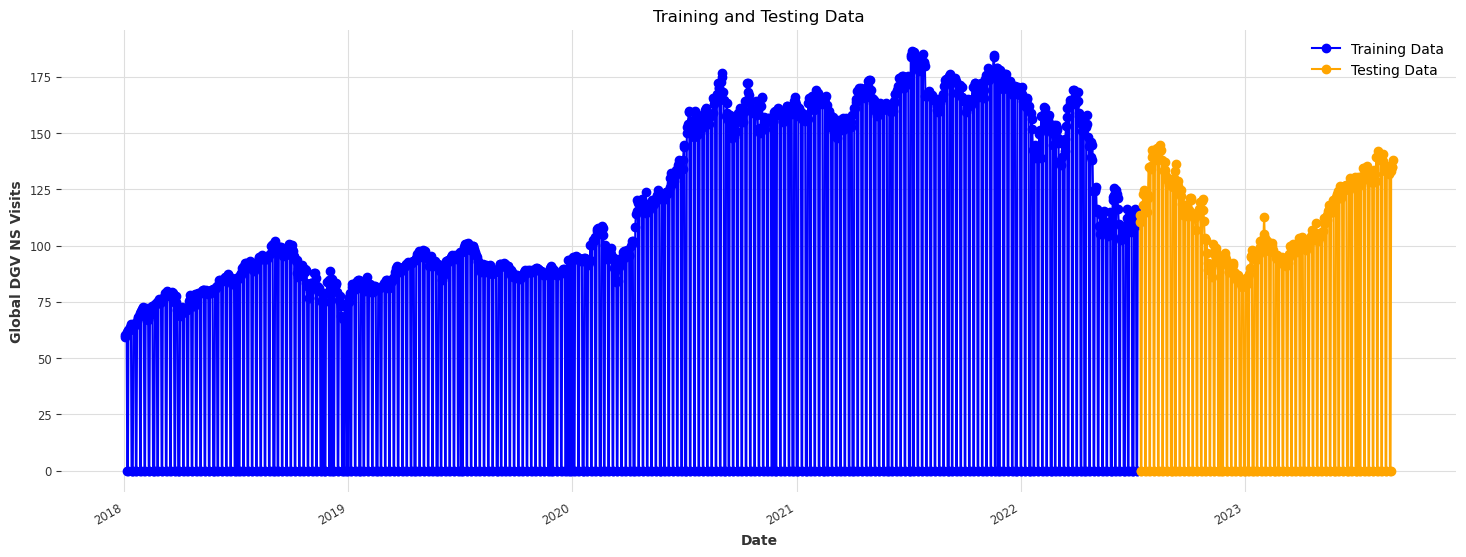

In [12]:
from darts import TimeSeries
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing daily data
series = TimeSeries.from_dataframe(
    df, "Date", "Close", freq="1D", fill_missing_dates=True, fillna_value=0
)


split_point = 0.80

train_series, test_series = series.split_after(split_point)

# Set the figure size and style
plt.figure(figsize=(18, 6))
# Plot the training and testing data
train_series.plot(label="Training Data", color="blue", linewidth=1.5, marker="o")
test_series.plot(label="Testing Data", color="orange", linewidth=1.5, marker="o")

# Add title and labels
plt.title("Training and Testing Data")
plt.xlabel("Date")
plt.ylabel("Amazon Close Price")

# Add grid lines
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()

## Inspect Seasonality

In [13]:
from darts.utils.statistics import plot_acf, check_seasonality

for m in range(2, 25):
    is_seasonal, period = check_seasonality(train_series, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


## Auto Correlation plot
The autocorrelation function (ACF) is used to identify the order of ARIMA models. The ACF plot shows the correlation between the time series and its lagged version. The lag at which the ACF plot crosses the upper confidence interval for the first time is considered as the order of the **MA** component of the ARIMA model. Similarly, if the ACF plot decays slowly, it indicates that there is a high degree of autocorrelation in the time series, which means that an AR component should be included in the ARIMA model.

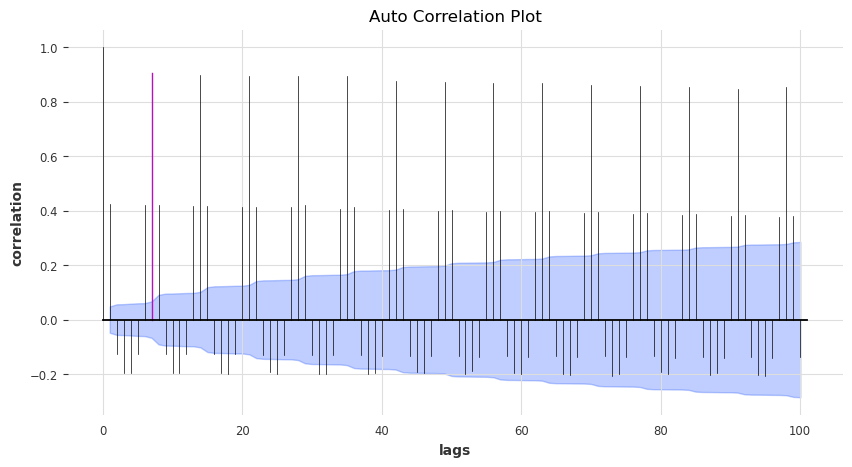

In [14]:
from darts.utils.statistics import plot_acf, plot_pacf


plot_acf(
    train_series, m=7, max_lag=100, fig_size=(10, 5), axis=None, default_formatting=True
)
plt.xlabel("lags")
plt.ylabel("correlation")
plt.title("Auto Correlation Plot")
plt.show()

## Partial Auto Correlation plot
The partial autocorrelation function (PACF) is also used to identify the order of ARIMA models. The PACF plot shows the correlation between the time series and its lagged version, but with the influence of the intermediate lags removed. The lag at which the PACF plot crosses the upper confidence interval for the first time is considered as the order of the **AR** component of the ARIMA model.

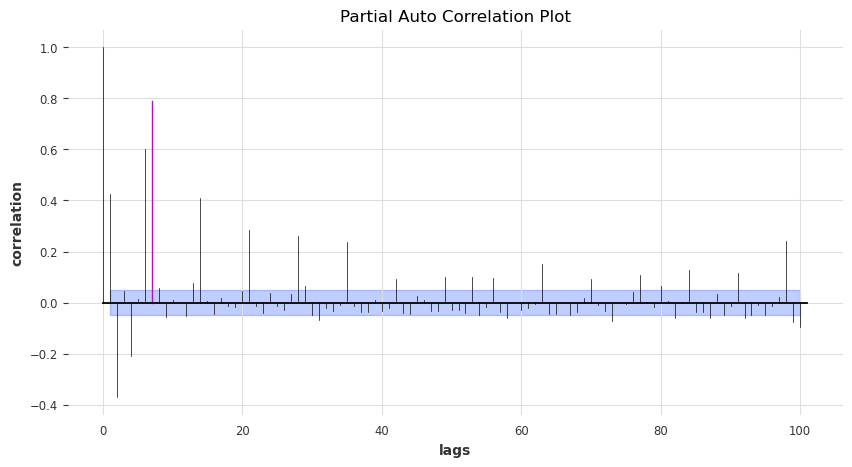

In [15]:
from darts.utils.statistics import plot_acf, plot_pacf

plot_pacf(
    train_series, m=7, max_lag=100, fig_size=(10, 5), axis=None, default_formatting=True
)

plt.xlabel("lags")
plt.ylabel("correlation")
plt.title("Partial Auto Correlation Plot")
plt.show()

# Model Fitting

## SARIMA Model

In [17]:
sarima_model = ARIMA(
    p=7,
    d=0,
    q=7,
    trend=None,
    random_state=1999,
    seasonal_order=(2, 1, 2, 14),
    add_encoders={
        "cyclic": {"future": ["month"]},
        "datetime_attribute": {"future": ["hour", "dayofweek"]},
        "position": {"future": ["relative"]},
        "custom": {"future": [lambda idx: (idx.year - 1950) / 50]},
        "transformer": Scaler(),
    },
)

sarima_model.fit(train_series)
sarima_model.model.summary()

/home/iffi/anaconda3/envs/darts/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                     y   No. Observations:                 1654
Model:             ARIMA(7, 0, 7)x(2, 1, [1, 2], 14)   Log Likelihood               -7363.269
Date:                               Sun, 10 Sep 2023   AIC                          14776.538
Time:                                       14:12:29   BIC                          14911.600
Sample:                                            0   HQIC                         14826.629
                                              - 1654                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             4.4823      3.061      1.464      0.143      -1.518      10.483
x2            -5.7599      2.757     -2.089      0.037     -11.164      -0.356
const      -1.533e-15   1802.882   -8.5e-19      1.000   -3533.583    3533.583
x3         -3.913e-06   1799.380  -2.17e-09      1.000   -3526.720    3526.720
x4            27.6021     44.562      0.619      0.536     -59.738     114.942
x5            -1.0566     15.511     -0.068      0.946     -31.457      29.344
ar.L1         -0.5609      0.315     -1.781      0.075      -1.178       0.056
ar.L2          0.4686      0.126      3.720      0.000       0.222       0.715
ar.L3          0.1250      0.098      1.277      0.202      -0.067       0.317
ar.L4         -0.1995      0.089     -2.246      0.025      -0.374      -0.025
ar.L5         -0.3850      0.092     -4.191      0.000      -0.565      -0.205
ar.L6          0.6901      0.111      6.190      0.000       0.472       0.909
ar.L7          0.8617      0.311      2.770      0.006       0.252       1.471
ma.L1          0.6618      0.301      2.198      0.028       0.072       1.252
ma.L2         -0.3673      0.094     -3.925      0.000      -0.551      -0.184
ma.L3         -0.1488      0.082     -1.823      0.068      -0.309       0.011
ma.L4          0.1686      0.079      2.124      0.034       0.013       0.324
ma.L5          0.4557      0.079      5.742      0.000       0.300       0.611
ma.L6         -0.5471      0.120     -4.573      0.000      -0.782      -0.313
ma.L7         -0.7913      0.261     -3.031      0.002      -1.303      -0.280
ar.S.L14      -0.6259      0.399     -1.570      0.116      -1.407       0.155
ar.S.L28       0.0162      0.030      0.542      0.588      -0.042       0.075
ma.S.L14      -0.3070      0.399     -0.769      0.442      -1.090       0.476
ma.S.L28      -0.5616      0.365     -1.537      0.124      -1.278       0.154
sigma2       467.4538      7.654     61.074      0.000     452.452     482.455
===================================================================================
Ljung-Box (L1) (Q):                   1.06   Jarque-Bera (JB):             57876.71
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               3.33   Skew:                            -4.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.59e+19. Standard errors may be unstable.
"""

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm


# Function to predict and evaluate
def predict_and_evaluate(
    window_size,
    prediction_horizon,
    slide_step,
    test_series,
    arima_model,
    result_plot_path,
):
    num_predictions = len(test_series) - window_size - prediction_horizon + 1

    meta_information_evaluation = {
        "Iterations": [],
        "MAE": [],
        "RMSE": [],
        "MAPE": [],
        "MSE": [],
        "input_window_size": [],
        "horizon": [],
        "stride": [],
    }

    try:
        for i in tqdm(range(0, num_predictions, slide_step)):
            input_window = test_series[i : i + window_size]
            ground_truth = test_series[
                i + window_size : i + window_size + prediction_horizon
            ]
            forecast = arima_model.predict(n=prediction_horizon, series=input_window)
            actual = ground_truth.values().flatten().tolist()
            predicted = forecast.values().flatten().tolist()
            metrics = calculate_metrics(actual, predicted)

            meta_information_evaluation["Iterations"].append(i)
            meta_information_evaluation["MAE"].append(metrics["MAE"])
            meta_information_evaluation["RMSE"].append(metrics["RMSE"])
            meta_information_evaluation["MAPE"].append(metrics["MAPE"])
            meta_information_evaluation["MSE"].append(metrics["MSE"])
            meta_information_evaluation["input_window_size"].append(window_size)
            meta_information_evaluation["horizon"].append(prediction_horizon)
            meta_information_evaluation["stride"].append(slide_step)

            bypass_information = {
                "slide_step": slide_step,
                "window_size": window_size,
                "horizon": prediction_horizon,
            }
            create_plots(
                input_window,
                forecast,
                ground_truth,
                result_plot_path,
                bypass_information,
            )

        evalaution_df = pd.DataFrame.from_dict(meta_information_evaluation)

        return evalaution_df

    except Exception as e:
        print("Error Occurred in fuction predict_and_evaluate():", e)
        evalaution_df = pd.DataFrame.from_dict(meta_information_evaluation)

        return evalaution_df


# Function to create plots
def create_plots(
    input_window, forecast, ground_truth, result_plot_path, bypass_information
):
    plt.figure(figsize=(30, 6))
    input_window.plot(label="Input Data", marker="o")
    forecast.plot(label="Predicted", marker="o")
    ground_truth.plot(label="Ground Truth", marker="o")

    combined_time_index = input_window.time_index.append(forecast.time_index).append(
        ground_truth.time_index
    )
    starting_date_of_input_data = input_window.time_index[0].strftime("%Y-%m-%d")
    ending_date_of_input_data = input_window.time_index[-1].strftime("%Y-%m-%d")
    starting_date_predicted = forecast.time_index[0].strftime("%Y-%m-%d")
    ending_date_of_predicted = forecast.time_index[-1].strftime("%Y-%m-%d")

    plt.xticks(
        combined_time_index, combined_time_index.strftime("%Y-%m-%d"), rotation=90
    )
    plt.title(
        f"Results of Input Data from {starting_date_of_input_data} to {ending_date_of_input_data} & Evaluation on from {starting_date_predicted} to {ending_date_of_predicted}",
        fontsize=16,
    )
    plt.ylabel("Amazon Close Price", fontsize=14)
    plt.xlabel("Dates", fontsize=14)
    plt.legend()

    plot_filename = f"{result_plot_path}/{bypass_information['window_size']}_{bypass_information['horizon']}_{bypass_information['slide_step']}.png"
    plt.savefig(plot_filename)
    plt.close()
    # plt.show()

# Model Evaluation

In [22]:
def model_evaluation(model_name, model_object, test_series, FileName):
    result_path = f"../ProcessedData/Results/{model_name}/{FileName}"
    result_plot_path = (
        f"../ProcessedData/Results/{model_name}/{FileName}/{model_name}_Plots"
    )
    os.makedirs(result_path, exist_ok=True)
    os.makedirs(result_plot_path, exist_ok=True)

    # Set your parameters
    window_sizes = [30, 45, 90]
    prediction_horizons = [15, 30, 35]
    slide_steps = [5, 10, 15]

    test_series = test_series
    model = model_object

    for window_size in window_sizes:
        for prediction_horizon in prediction_horizons:
            for slide_step in slide_steps:
                print(
                    f"Iteration : Window size : {window_size} Horizan: {prediction_horizon}, Stride : {slide_step}"
                )
                evaluation_df = predict_and_evaluate(
                    window_size,
                    prediction_horizon,
                    slide_step,
                    test_series,
                    model,
                    result_plot_path,
                )
                evaluation_df.to_csv(
                    f"{result_path}/window_size_{window_size}_horizon_{prediction_horizon}_stride_{slide_step}.csv",
                    index=False,
                )

                print(
                    f"Window_size_{window_size}_prediction_horizon_{prediction_horizon}_slide_step_{slide_step} - Evaluation completed."
                )
        #         break
        #     break
        # break

## SARIMA Model Evaluation

In [23]:
model_name = "SARIMA"
model_object = sarima_model
FileName = fileName
test_series = test_series
model_evaluation(model_name, model_object, test_series, FileName)

Iteration : Window size : 30 Horizan: 15, Stride : 5


  0%|          | 0/74 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  1%|▏         | 1/74 [00:01<01:36,  1.32s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  3%|▎         | 2/74 [00:02<01:29,  1.24s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  4%|▍         | 3/74 [00:03<01:24,  1.19s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  5%|▌         | 4/74 [00:04<01:18,  1.12s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  7%|▋  

Window_size_30_prediction_horizon_15_slide_step_5 - Evaluation completed.
Iteration : Window size : 30 Horizan: 15, Stride : 10


  0%|          | 0/37 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  3%|▎         | 1/37 [00:01<00:45,  1.28s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  5%|▌         | 2/37 [00:02<00:42,  1.21s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  8%|▊         | 3/37 [00:03<00:41,  1.22s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 11%|█         | 4/37 [00:04<00:39,  1.21s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 14%|█▎ 

Window_size_30_prediction_horizon_15_slide_step_10 - Evaluation completed.
Iteration : Window size : 30 Horizan: 15, Stride : 15


  0%|          | 0/25 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  4%|▍         | 1/25 [00:01<00:28,  1.17s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  8%|▊         | 2/25 [00:02<00:26,  1.17s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 12%|█▏        | 3/25 [00:03<00:25,  1.18s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 16%|█▌        | 4/25 [00:04<00:24,  1.18s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 20%|██ 

Window_size_30_prediction_horizon_15_slide_step_15 - Evaluation completed.
Iteration : Window size : 30 Horizan: 30, Stride : 5


  0%|          | 0/71 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  1%|▏         | 1/71 [00:01<01:39,  1.42s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  3%|▎         | 2/71 [00:02<01:33,  1.35s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  4%|▍         | 3/71 [00:03<01:28,  1.31s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  6%|▌         | 4/71 [00:05<01:40,  1.50s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  7%|▋  

Window_size_30_prediction_horizon_30_slide_step_5 - Evaluation completed.
Iteration : Window size : 30 Horizan: 30, Stride : 10


  0%|          | 0/36 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  3%|▎         | 1/36 [00:01<00:49,  1.41s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  6%|▌         | 2/36 [00:02<00:47,  1.40s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  8%|▊         | 3/36 [00:04<00:44,  1.36s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 11%|█         | 4/36 [00:05<00:44,  1.39s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 14%|█▍ 

Window_size_30_prediction_horizon_30_slide_step_10 - Evaluation completed.
Iteration : Window size : 30 Horizan: 30, Stride : 15


  0%|          | 0/24 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  4%|▍         | 1/24 [00:01<00:29,  1.28s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  8%|▊         | 2/24 [00:02<00:28,  1.28s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 12%|█▎        | 3/24 [00:03<00:26,  1.26s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 17%|█▋        | 4/24 [00:05<00:25,  1.26s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 21%|██ 

Window_size_30_prediction_horizon_30_slide_step_15 - Evaluation completed.
Iteration : Window size : 30 Horizan: 35, Stride : 5


  0%|          | 0/70 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  1%|▏         | 1/70 [00:01<01:29,  1.29s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  3%|▎         | 2/70 [00:02<01:31,  1.35s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  4%|▍         | 3/70 [00:04<01:30,  1.35s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  6%|▌         | 4/70 [00:05<01:30,  1.37s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  7%|▋  

Window_size_30_prediction_horizon_35_slide_step_5 - Evaluation completed.
Iteration : Window size : 30 Horizan: 35, Stride : 10


  0%|          | 0/35 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  3%|▎         | 1/35 [00:01<00:50,  1.48s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  6%|▌         | 2/35 [00:02<00:46,  1.41s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  9%|▊         | 3/35 [00:04<00:46,  1.45s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 11%|█▏        | 4/35 [00:05<00:47,  1.53s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 14%|█▍ 

Window_size_30_prediction_horizon_35_slide_step_10 - Evaluation completed.
Iteration : Window size : 30 Horizan: 35, Stride : 15


  0%|          | 0/24 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  4%|▍         | 1/24 [00:06<02:39,  6.93s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  8%|▊         | 2/24 [00:15<02:47,  7.61s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 12%|█▎        | 3/24 [00:33<04:25, 12.63s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 17%|█▋        | 4/24 [00:52<04:59, 15.00s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 21%|██ 

Window_size_30_prediction_horizon_35_slide_step_15 - Evaluation completed.
Iteration : Window size : 45 Horizan: 15, Stride : 5


  0%|          | 0/71 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  1%|▏         | 1/71 [00:33<39:04, 33.50s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  3%|▎         | 2/71 [01:49<1:07:08, 58.38s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  4%|▍         | 3/71 [02:06<44:44, 39.48s/it]  /tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  6%|▌         | 4/71 [02:16<31:15, 27.99s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  7%

Window_size_45_prediction_horizon_15_slide_step_5 - Evaluation completed.
Iteration : Window size : 45 Horizan: 15, Stride : 10


  0%|          | 0/36 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  3%|▎         | 1/36 [00:01<00:42,  1.20s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  6%|▌         | 2/36 [00:02<00:42,  1.25s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  8%|▊         | 3/36 [00:03<00:44,  1.34s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 11%|█         | 4/36 [00:05<00:43,  1.35s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 14%|█▍ 

Window_size_45_prediction_horizon_15_slide_step_10 - Evaluation completed.
Iteration : Window size : 45 Horizan: 15, Stride : 15


  0%|          | 0/24 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  4%|▍         | 1/24 [00:01<00:28,  1.26s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  8%|▊         | 2/24 [00:02<00:26,  1.22s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 12%|█▎        | 3/24 [00:03<00:26,  1.26s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 17%|█▋        | 4/24 [00:04<00:24,  1.24s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 21%|██ 

Window_size_45_prediction_horizon_15_slide_step_15 - Evaluation completed.
Iteration : Window size : 45 Horizan: 30, Stride : 5


  0%|          | 0/68 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  1%|▏         | 1/68 [00:01<01:28,  1.31s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  3%|▎         | 2/68 [00:02<01:27,  1.33s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  4%|▍         | 3/68 [00:04<01:26,  1.34s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  6%|▌         | 4/68 [00:05<01:27,  1.37s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  7%|▋  

Window_size_45_prediction_horizon_30_slide_step_5 - Evaluation completed.
Iteration : Window size : 45 Horizan: 30, Stride : 10


  0%|          | 0/34 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  3%|▎         | 1/34 [00:01<00:46,  1.40s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  6%|▌         | 2/34 [00:02<00:42,  1.33s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  9%|▉         | 3/34 [00:04<00:41,  1.34s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 12%|█▏        | 4/34 [00:05<00:41,  1.38s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 15%|█▍ 

Window_size_45_prediction_horizon_30_slide_step_10 - Evaluation completed.
Iteration : Window size : 45 Horizan: 30, Stride : 15


  0%|          | 0/23 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  4%|▍         | 1/23 [00:01<00:32,  1.47s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  9%|▊         | 2/23 [00:02<00:30,  1.44s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 13%|█▎        | 3/23 [00:04<00:28,  1.41s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 17%|█▋        | 4/23 [00:05<00:26,  1.42s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 22%|██▏

Window_size_45_prediction_horizon_30_slide_step_15 - Evaluation completed.
Iteration : Window size : 45 Horizan: 35, Stride : 5


  0%|          | 0/67 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  1%|▏         | 1/67 [00:01<01:33,  1.42s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  3%|▎         | 2/67 [00:02<01:30,  1.40s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  4%|▍         | 3/67 [00:04<01:29,  1.40s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  6%|▌         | 4/67 [00:05<01:27,  1.39s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  7%|▋  

Window_size_45_prediction_horizon_35_slide_step_5 - Evaluation completed.
Iteration : Window size : 45 Horizan: 35, Stride : 10


  0%|          | 0/34 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  3%|▎         | 1/34 [00:01<00:49,  1.50s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  6%|▌         | 2/34 [00:02<00:45,  1.43s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  9%|▉         | 3/34 [00:04<00:44,  1.45s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 12%|█▏        | 4/34 [00:05<00:43,  1.47s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 15%|█▍ 

Window_size_45_prediction_horizon_35_slide_step_10 - Evaluation completed.
Iteration : Window size : 45 Horizan: 35, Stride : 15


  0%|          | 0/23 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  4%|▍         | 1/23 [00:01<00:30,  1.39s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  9%|▊         | 2/23 [00:02<00:29,  1.40s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 13%|█▎        | 3/23 [00:04<00:28,  1.41s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 17%|█▋        | 4/23 [00:05<00:26,  1.40s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 22%|██▏

Window_size_45_prediction_horizon_35_slide_step_15 - Evaluation completed.
Iteration : Window size : 90 Horizan: 15, Stride : 5


  0%|          | 0/62 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  2%|▏         | 1/62 [00:01<01:33,  1.53s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  3%|▎         | 2/62 [00:03<01:30,  1.51s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  5%|▍         | 3/62 [00:04<01:27,  1.47s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  6%|▋         | 4/62 [00:05<01:25,  1.48s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  8%|▊  

Window_size_90_prediction_horizon_15_slide_step_5 - Evaluation completed.
Iteration : Window size : 90 Horizan: 15, Stride : 10


  0%|          | 0/31 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  3%|▎         | 1/31 [00:01<00:45,  1.52s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  6%|▋         | 2/31 [00:02<00:43,  1.49s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 10%|▉         | 3/31 [00:04<00:41,  1.50s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 13%|█▎        | 4/31 [00:06<00:40,  1.50s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 16%|█▌ 

Window_size_90_prediction_horizon_15_slide_step_10 - Evaluation completed.
Iteration : Window size : 90 Horizan: 15, Stride : 15


  0%|          | 0/21 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  5%|▍         | 1/21 [00:01<00:32,  1.60s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 10%|▉         | 2/21 [00:03<00:28,  1.52s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 14%|█▍        | 3/21 [00:04<00:26,  1.49s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 19%|█▉        | 4/21 [00:05<00:24,  1.45s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 24%|██▍

Window_size_90_prediction_horizon_15_slide_step_15 - Evaluation completed.
Iteration : Window size : 90 Horizan: 30, Stride : 5


  0%|          | 0/59 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  2%|▏         | 1/59 [00:01<01:29,  1.55s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  3%|▎         | 2/59 [00:03<01:31,  1.60s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  5%|▌         | 3/59 [00:04<01:30,  1.61s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  7%|▋         | 4/59 [00:06<01:28,  1.61s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  8%|▊  

Window_size_90_prediction_horizon_30_slide_step_5 - Evaluation completed.
Iteration : Window size : 90 Horizan: 30, Stride : 10


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  3%|▎         | 1/30 [00:01<00:47,  1.65s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  7%|▋         | 2/30 [00:03<00:47,  1.70s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 10%|█         | 3/30 [00:05<00:44,  1.66s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 13%|█▎        | 4/30 [00:06<00:42,  1.62s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 17%|█▋ 

Window_size_90_prediction_horizon_30_slide_step_10 - Evaluation completed.
Iteration : Window size : 90 Horizan: 30, Stride : 15


  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  5%|▌         | 1/20 [00:01<00:31,  1.65s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 10%|█         | 2/20 [00:03<00:29,  1.66s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 15%|█▌        | 3/20 [00:05<00:28,  1.68s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 20%|██        | 4/20 [00:06<00:26,  1.68s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 25%|██▌

Window_size_90_prediction_horizon_30_slide_step_15 - Evaluation completed.
Iteration : Window size : 90 Horizan: 35, Stride : 5


  0%|          | 0/58 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  2%|▏         | 1/58 [00:01<01:35,  1.68s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  3%|▎         | 2/58 [00:03<01:32,  1.66s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  5%|▌         | 3/58 [00:05<01:32,  1.67s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  7%|▋         | 4/58 [00:06<01:31,  1.69s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  9%|▊  

Window_size_90_prediction_horizon_35_slide_step_5 - Evaluation completed.
Iteration : Window size : 90 Horizan: 35, Stride : 10


  0%|          | 0/29 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  3%|▎         | 1/29 [00:01<00:47,  1.69s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  7%|▋         | 2/29 [00:03<00:44,  1.66s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 10%|█         | 3/29 [00:04<00:42,  1.64s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 14%|█▍        | 4/29 [00:06<00:42,  1.69s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 17%|█▋ 

Window_size_90_prediction_horizon_35_slide_step_10 - Evaluation completed.
Iteration : Window size : 90 Horizan: 35, Stride : 15


  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
  5%|▌         | 1/20 [00:01<00:31,  1.65s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 10%|█         | 2/20 [00:03<00:29,  1.65s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 15%|█▌        | 3/20 [00:05<00:29,  1.74s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 20%|██        | 4/20 [00:06<00:28,  1.75s/it]/tmp/ipykernel_64145/1072158584.py:11: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((predicted - actual) / actual)) * 100
 25%|██▌

Window_size_90_prediction_horizon_35_slide_step_15 - Evaluation completed.


: 

# Evaluate metrics

In [3]:
import pandas as pd
import glob


def aggregate_evaluation_results(file_pattern):
    eval_dict = {
        "window_size": [],
        "horizan": [],
        "stride": [],
        "AVG_MAE": [],
        "AVG_MSE": [],
        "AVG_RMSE": [],
        "AVG_MAPE": [],
    }

    paths = glob.glob(file_pattern)

    for path in paths:
        window_size = path.split("/")[-1].split("_")[2]
        horizan = path.split("/")[-1].split("_")[4]
        stride = path.split("/")[-1].split("_")[6].split(".")[0]

        df = pd.read_csv(path)
        eval_dict["window_size"].append(window_size)
        eval_dict["horizan"].append(horizan)
        eval_dict["stride"].append(stride)

        eval_dict["AVG_MAE"].append(df["MAE"].mean())
        eval_dict["AVG_MSE"].append(df["MSE"].mean())
        eval_dict["AVG_RMSE"].append(df["RMSE"].mean())
        eval_dict["AVG_MAPE"].append(df["MAPE"].mean())

    eval_df = pd.DataFrame.from_dict(eval_dict)
    eval_df = eval_df.dropna()
    eval_df.sort_values(
        ["window_size", "horizan", "stride"], inplace=True, ascending=True
    )

    return eval_df


# Example usage
file_pattern = "../ProcessedData/Results/SARIMA/amazon/*.csv"
result_df = aggregate_evaluation_results(file_pattern)
result_df = result_df[['window_size','horizan','stride','AVG_MAE','AVG_MSE','AVG_RMSE']]
result_df

,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
5,30,15,10,13.715495,592.158022,22.415665
15,30,15,15,12.986407,546.397418,21.338439
23,30,15,5,13.548106,576.249567,22.193999
14,30,30,10,16.588987,708.784302,25.696146
26,30,30,15,16.104400,689.539126,25.202501
10,30,30,5,16.475623,707.927162,25.631796
16,30,35,10,17.499579,744.664131,26.448151
2,30,35,15,16.740201,699.877758,25.479731
3,30,35,5,17.418305,748.616672,26.435076
8,45,15,10,12.800020,513.374147,20.805133


In [4]:
for name , group in result_df.groupby(['window_size','horizan']):
    print(name)
    display(group)    

('30', '15')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
5,30,15,10,13.715495,592.158022,22.415665
15,30,15,15,12.986407,546.397418,21.338439
23,30,15,5,13.548106,576.249567,22.193999


('30', '30')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
14,30,30,10,16.588987,708.784302,25.696146
26,30,30,15,16.104400,689.539126,25.202501
10,30,30,5,16.475623,707.927162,25.631796


('30', '35')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
16,30,35,10,17.499579,744.664131,26.448151
2,30,35,15,16.740201,699.877758,25.479731
3,30,35,5,17.418305,748.616672,26.435076


('45', '15')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
8,45,15,10,12.800020,513.374147,20.805133
20,45,15,15,12.638867,511.707575,20.335294
18,45,15,5,12.533623,504.293049,20.488449


('45', '30')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
19,45,30,10,14.457269,566.576030,22.869957
11,45,30,15,14.352402,567.189955,22.717468
9,45,30,5,14.221611,555.622165,22.630396


('45', '35')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
4,45,35,10,15.191650,594.616832,23.622343
7,45,35,15,14.655570,567.063918,22.863814
13,45,35,5,14.785314,574.404467,23.147915


('90', '15')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
12,90,15,10,11.921575,423.912866,18.714305
25,90,15,15,11.677826,424.719031,18.565015
24,90,15,5,11.797688,429.170197,18.844962


('90', '30')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
1,90,30,10,13.408382,483.504497,21.272097
22,90,30,15,13.130923,484.380052,21.096043
17,90,30,5,13.185168,482.723467,21.190868


('90', '35')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE
0,90,35,10,13.825181,503.741324,21.852576
6,90,35,15,13.198690,471.246218,21.077114
21,90,35,5,13.616821,500.341929,21.775021
